    Author: Nithin Akgilesh Venkat
    Date: 27.10.2021
    Topic: Cats life expectancy prediction

**Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [2]:
df = pd.read_csv("cats.csv" , sep=',', index_col =0)
df.head()

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight
0,7.0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0
1,9.0,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0
2,8.0,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0
3,8.0,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0
4,8.0,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0


In [3]:
df

,age at death,breed,date of last vet visit,hair length,height,number of vet visits,weight
0,7.0,Siamese,2009-08-02 14:02:18,0.883886,21.611951,5,4.0
1,9.0,Siamese,2013-11-27 19:08:52,1.221535,26.451956,10,4.0
2,8.0,Manx,2016-01-12 04:39:24,0.967718,18.540191,10,5.0
3,8.0,Maine Coon,2000-11-24 18:51:18,1.090641,16.564362,12,7.0
4,8.0,Maine Coon,2014-07-03 22:17:26,1.004712,22.535495,7,7.0
...,...,...,...,...,...,...,...
295,8.0,Manx,2006-01-06 11:52:45,0.878575,26.812670,14,1.0
296,8.0,Manx,1997-10-24 15:06:57,1.041003,16.920258,5,4.0
297,7.0,Maine Coon,2008-06-06 21:09:50,1.053361,14.106118,9,3.0
298,15.0,Maine Coon,1999-09-19 20:19:43,1.063393,12.210901,10,2.0


    General overall view of the dataset

In [4]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

df.info()
df.isnull().sum()

Rows     :  300
Columns  :  7

Features :  ['age at death', 'breed', 'date of last vet visit', 'hair length', 'height', 'number of vet visits', 'weight']

Missing values :   2

Unique values :  
 age at death               18
breed                       6
date of last vet visit    300
hair length               299
height                    300
number of vet visits       21
weight                     12
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age at death            299 non-null    float64
 1   breed                   300 non-null    object 
 2   date of last vet visit  300 non-null    object 
 3   hair length             299 non-null    float64
 4   height                  300 non-null    float64
 5   number of vet visits    300 non-null    int64  
 6   weight                  300 non-null    float64


age at death              1
breed                     0
date of last vet visit    0
hair length               1
height                    0
number of vet visits      0
weight                    0
dtype: int64

**Data Prepocessing**

    we can see two columns have missing values. lets do a quick data technique for filling them.

In [5]:
# Converting the feature names to standard format for further processing
orig_cols = list(df.columns) 
new_cols = [] 
for col in orig_cols:     
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower()) 

df.columns = new_cols



In [6]:
df.describe()

,age_at_death,hair_length,height,number_of_vet_visits,weight
count,299.000000,2.990000e+02,300.000000,300.000000,300.000000
mean,9.006689,3.027706e+09,20.498442,8.296667,3.957667
std,2.892937,5.235392e+10,5.107386,3.820643,2.033624
min,0.000000,6.904537e-01,5.077179,-1.000000,0.000000
25%,7.000000,9.377535e-01,16.958241,6.000000,2.000000
50%,9.000000,1.003253e+00,20.825805,8.000000,4.000000
75%,11.000000,1.067127e+00,24.043067,11.000000,5.250000
max,18.000000,9.052840e+11,33.043014,19.000000,10.000000


    The above describe() function shows us some info that needs to be fixed in the dataset before any data analysis.
    1. Fill missing values using mean/mode inputers
    2. number_vet_visits cannot be -1 
    3. weight cannot be 0 for any cat

    The above issues can be fixed using filling values with mean/mode distributioon depending on the data distribution.

    Outliers are unusual values in your dataset, and they can distort statistical analyses and violate their assumptions.Outliers increase the variability in your data, which decreases statistical power. Consequently, excluding outliers can cause your results to become statistically significant.

In [7]:

# Remove the outliers using the interquartile range (IQR).
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]



# Print the dimensions of the cleaned dataset.
df.shape

(290, 7)

    Visualising data feature distribution to get an overall view
    Box plots gives us the data distibution of individual features

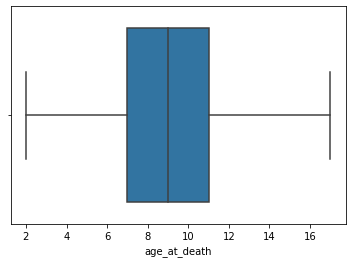

In [8]:
sns.boxplot(df.age_at_death)

    For symmetric data distribution, we can use the mean value for inputing missing/incorrect values.
    
    Similar process will be carried out for other features as well

In [9]:
df['age_at_death'].fillna(value=df['age_at_death'].mean(), inplace=True)

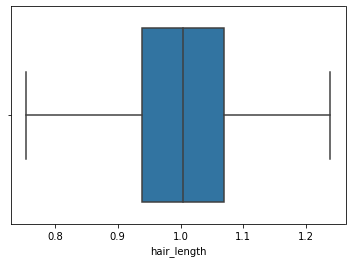

In [10]:
sns.boxplot(df.hair_length)

    When the data is skewed, it is good to consider using mode values for replacing the missing values

In [11]:
df['hair_length'] = df['hair_length'].fillna(df['hair_length'].mode()[0])

    Final check to confirm if the data is clean for further analysis

In [12]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_at_death            290 non-null    float64
 1   breed                   290 non-null    object 
 2   date_of_last_vet_visit  290 non-null    object 
 3   hair_length             290 non-null    float64
 4   height                  290 non-null    float64
 5   number_of_vet_visits    290 non-null    int64  
 6   weight                  290 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 18.1+ KB


age_at_death              0
breed                     0
date_of_last_vet_visit    0
hair_length               0
height                    0
number_of_vet_visits      0
weight                    0
dtype: int64

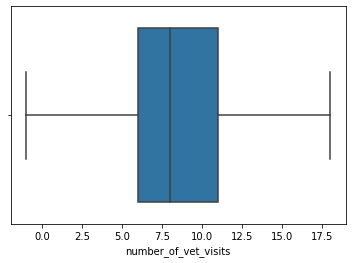

In [13]:
sns.boxplot(df.number_of_vet_visits)

    no# of vet visits cannot be -1 because last visit date provided the neccessary details
    so assigning mean column in place of -1

In [14]:
df["number_of_vet_visits"].replace({-1: (df['number_of_vet_visits'].mean()), 0: (df['number_of_vet_visits'].mean())}, inplace=True)


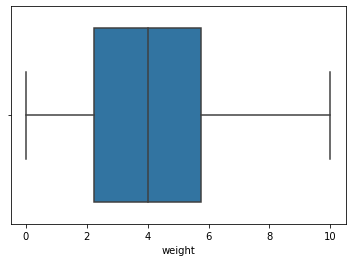

In [15]:
sns.boxplot(df.weight)

    weight cannot be 0 for a cat, especially when its old. So filling them with mode value as the data is skewed

In [16]:
df["weight"].replace({0: (df['weight'].mean())}, inplace=True)


In [17]:
df.describe()

,age_at_death,hair_length,height,number_of_vet_visits,weight
count,290.000000,290.000000,290.000000,290.000000,290.000000
mean,9.020761,1.005056,20.658652,8.489703,4.103329
std,2.732526,0.097253,4.997634,3.499363,1.897918
min,2.000000,0.753671,6.719702,1.000000,1.000000
25%,7.000000,0.938083,17.027839,6.000000,3.000000
50%,9.000000,1.004265,20.885836,8.000000,4.000000
75%,11.000000,1.067898,24.185278,11.000000,5.750000
max,17.000000,1.238662,33.043014,18.000000,10.000000


In [18]:
# analysing the data types of features
df.dtypes

age_at_death              float64
breed                      object
date_of_last_vet_visit     object
hair_length               float64
height                    float64
number_of_vet_visits      float64
weight                    float64
dtype: object

In [19]:
# Discard the metadata (breed, vet visits).
df = df.drop(['breed' ,'date_of_last_vet_visit'], axis=1)

In [20]:
df

,age_at_death,hair_length,height,number_of_vet_visits,weight
0,7.0,0.883886,21.611951,5.0,4.0
1,9.0,1.221535,26.451956,10.0,4.0
2,8.0,0.967718,18.540191,10.0,5.0
3,8.0,1.090641,16.564362,12.0,7.0
4,8.0,1.004712,22.535495,7.0,7.0
...,...,...,...,...,...
295,8.0,0.878575,26.812670,14.0,1.0
296,8.0,1.041003,16.920258,5.0,4.0
297,7.0,1.053361,14.106118,9.0,3.0
298,15.0,1.063393,12.210901,10.0,2.0


**Data Exploration**

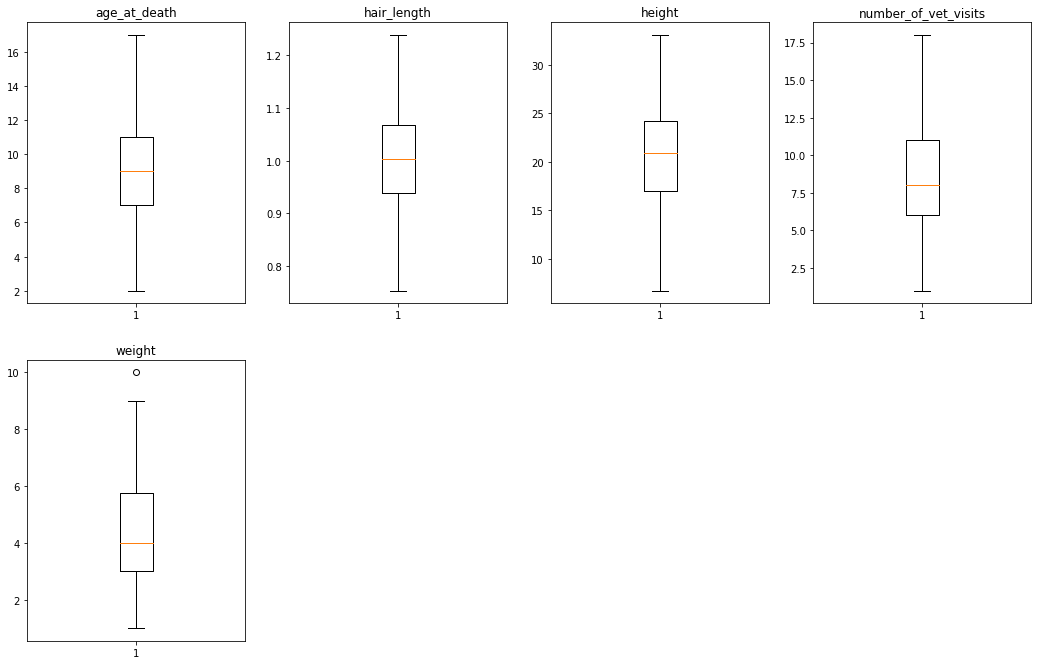

(290, 5)

In [21]:
# creating box plots

# Create a dictionary of columns representing the features of the dataset.
col_dict = {'age_at_death':1,'hair_length':2,'height':3,'number_of_vet_visits':4,'weight':5}

# Visualize the data for each feature using box plots.
plt.figure(figsize=(18,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.title(variable)

plt.show()
df.shape

    A heatmap is a graphical representation where individual values of a matrix are represented as colors. A heatmap is very useful in visualizing the concentration of values between two dimensions of a matrix. This helps in finding patterns and gives a perspective of depth.

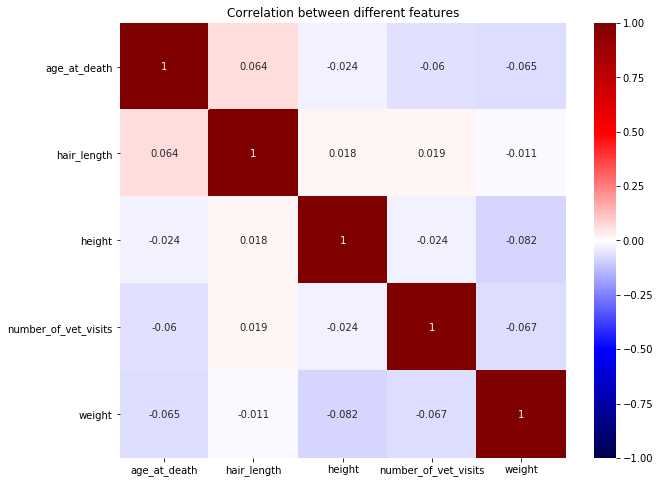

In [22]:
# Plot heatmap to visualize the correlations.
plt.figure(figsize = (10, 8))
# sns.heatmap(df.corr(), annot = True)
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.title('Correlation between different features');

    Since the no. of samples is less in the dataset, there seems to be less correlation between features 


    Scatter plots' primary uses are to observe and show relationships between two numeric variables. Relationships between variables can be described in many ways: positive or negative, strong or weak, linear or nonlinear. A scatter plot can also be useful for identifying other patterns in data.

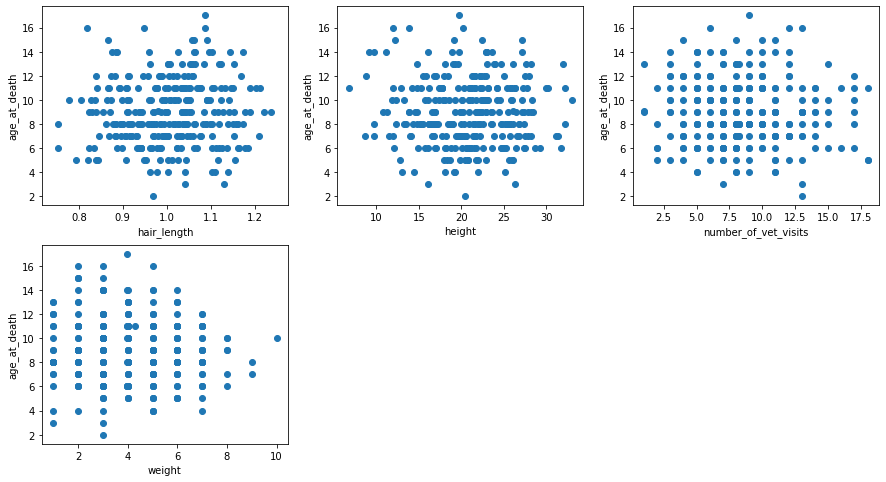

In [23]:

# Create a vector containing all the features of the dataset.
all_col = ['hair_length','height','number_of_vet_visits','weight']

plt.figure(figsize=(15,30))

# Plot each feature in function of the target variable (age_at_death) using scatter plots.
for i in range(len(all_col)):
    plt.subplot(7,3,i+1)
    plt.scatter(df[all_col[i]], df['age_at_death'])
    plt.xlabel(all_col[i])
    plt.ylabel('age_at_death')

plt.show()

There is no evidence of any tight corelation in data, porobably the sample size could be an issue.(random scatter of the points)

**Data Analysis**

In [24]:
df_copy = df.copy()

In [25]:
# Y label of the model will be age_at_death column. So we seperate it from the dataframe.
y = df['age_at_death']
df = df.drop(labels='age_at_death', axis=1)
df

,hair_length,height,number_of_vet_visits,weight
0,0.883886,21.611951,5.0,4.0
1,1.221535,26.451956,10.0,4.0
2,0.967718,18.540191,10.0,5.0
3,1.090641,16.564362,12.0,7.0
4,1.004712,22.535495,7.0,7.0
...,...,...,...,...
295,0.878575,26.812670,14.0,1.0
296,1.041003,16.920258,5.0,4.0
297,1.053361,14.106118,9.0,3.0
298,1.063393,12.210901,10.0,2.0


In [26]:
y = y.to_numpy(dtype='float64')
y

array([ 7.        ,  9.        ,  8.        ,  8.        ,  8.        ,
        6.        , 10.        , 10.        , 13.        , 12.        ,
        7.        ,  8.        ,  7.        ,  5.        ,  9.        ,
       14.        ,  6.        , 11.        ,  5.        , 12.        ,
       10.        ,  7.        ,  9.        ,  8.        ,  6.        ,
        9.        , 11.        ,  5.        , 14.        ,  9.        ,
        9.        , 11.        ,  6.        ,  8.        ,  7.        ,
       10.        ,  6.        , 10.        ,  5.        ,  7.        ,
       11.        , 10.        , 11.        , 13.        , 11.        ,
        8.        ,  7.        , 10.        ,  6.        ,  7.        ,
       10.        ,  8.        , 14.        , 14.        ,  6.        ,
       11.        , 13.        , 10.        , 11.        ,  6.        ,
        7.        ,  8.        , 10.        ,  9.        ,  9.        ,
       13.        ,  5.        ,  7.        ,  9.        ,  4.  

In [27]:
# Dividing the dataset into train, validation and test sets. %80 training set, %10 validation set, %10 test set.

x_train, x_test, y_train, y_test = model_selection.train_test_split(df, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)
print(f'X_train shape -->{x_train.shape}')
print(f'X_valid shape -->{x_valid.shape}')
print(f'X_test shape -->{x_test.shape}')
print(f'y_train shape -->{y_train.shape}')
print(f'y_valid shape -->{y_valid.shape}')
print(f'y_test shape -->{y_test.shape}')

X_train shape -->(232, 4)
X_valid shape -->(29, 4)
X_test shape -->(29, 4)
y_train shape -->(232,)
y_valid shape -->(29,)
y_test shape -->(29,)


Standardization the features using Sklearn. Fitted the train set (because we only want to use these values) and transformed all sets.

In [28]:

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

**Model 1: Linear Regression**

    Using Linear Regression as the first model. Model is trained on the train set and made predictions for validation set. Mean Squared Error is used to compute the loss.

In [29]:

model = linear_model.LinearRegression()
model.fit(X=x_train, y=y_train)
val_hat = model.predict(x_valid)
metrics.mean_squared_error(y_valid, val_hat)


8.97515329115397

**Model 2: Poisson Regressor**

    Using Poisson Regressor as the second model. Defined the hyper-parameter alpha as 0.1 and maximum iterations is 100 (default setting). 

In [30]:
poisson = linear_model.PoissonRegressor(alpha=1, max_iter=100)
poisson.fit(X=x_train, y=y_train)
poi_hat = poisson.predict(x_valid)
metrics.mean_squared_error(y_valid, poi_hat)

8.887134708894676


**Model 3: Gamma Regressor**

    Using Gamma Regressor as the last model. Used the same parameters as the Poisson Regressor. The Mean Squared Error is lower, so we will use the Gamma Regressor on our test set.

In [31]:
gamma = linear_model.GammaRegressor(alpha=1, max_iter=100)
gamma.fit(x_train, y_train)
gamma_val = gamma.predict(x_valid)
metrics.mean_squared_error(y_valid, gamma_val)

8.532629216509475

Testing with Gamma progessor on test dataset

In [32]:
gamma_test = gamma.predict(x_test)
print(f'r2score --> {metrics.r2_score(y_test, gamma_test)}')

r2score --> -0.08107461766439816


**Analysis:** 

    The negative R-squared value means that the prediction tends to be less accurate that the average value of the data set over time.

    Correlation coefficient is low which indicates less relationship between the variables (random scatter of the points)

**Solution:**

    When more variables(features) are added, r-squared values typically increases.

**Extended analysis on correlation using OLS regression**

    When working with small datasets in general, your best bet is resampling. 
    In other words, this would involve finding the mean and standard deviation of the samples 
    in your existing data, and then generating random data that would conform to the same mean and standard deviation.

In [33]:

mu=np.mean(df.hair_length)
mu


1.005055778830227

In [34]:
stdev=np.std(df.hair_length)
stdev

0.09708475960653629

In [35]:
s_hair_length = np.random.normal(mu, stdev, 2000)
s_hair_length

array([0.82363209, 1.07442743, 0.97339818, ..., 1.10508599, 1.13991006,
       0.94286874])

In [36]:
mu=np.mean(df.number_of_vet_visits)
stdev=np.std(df.number_of_vet_visits)

s_number_of_vet_visits = np.random.normal(mu, stdev, 2000)
s_number_of_vet_visits

array([ 7.34164201,  6.8271422 ,  6.44462395, ...,  4.49145942,
       10.53065368, 11.54200812])

In [37]:
mu=np.mean(df.weight)
stdev=np.std(df.weight)

s_weight = np.random.normal(mu, stdev, 2000)
s_weight



array([4.61530432, 3.32640845, 5.51722234, ..., 4.4620533 , 5.411571  ,
       7.05123788])

In [38]:
mu=np.mean(df.height)
stdev=np.std(df.height)

s_height = np.random.normal(mu, stdev, 2000)
s_height




array([23.72421602, 24.39363342, 24.03647036, ..., 18.63538439,
       15.04799202, 23.10670049])

In [39]:
mu=np.mean(df_copy.age_at_death)
stdev=np.std(df_copy.age_at_death)

s_age_at_death = np.random.normal(mu, stdev, 2000)
s_age_at_death





array([7.89981893, 7.04006014, 6.17585425, ..., 4.31015832, 9.01222241,
       7.26981131])

In [40]:
# creating new dataframe with resampled variables
df_2000 = pd.DataFrame(zip(s_age_at_death,s_hair_length,s_height, s_number_of_vet_visits,s_weight), columns=['age_at_death','hair_length','height', 'number_of_vet_visits','weight'])
print(df_2000)

      age_at_death  hair_length     height  number_of_vet_visits    weight
0         7.899819     0.823632  23.724216              7.341642  4.615304
1         7.040060     1.074427  24.393633              6.827142  3.326408
2         6.175854     0.973398  24.036470              6.444624  5.517222
3         9.262417     0.977253  19.386631              6.802259  4.807996
4         5.185937     0.935546  13.772839              8.078909  5.889417
...            ...          ...        ...                   ...       ...
1995      4.755730     0.860243  22.251403              6.855063  6.026874
1996     11.273952     0.915855  19.835606              9.002651  3.360237
1997      4.310158     1.105086  18.635384              4.491459  4.462053
1998      9.012222     1.139910  15.047992             10.530654  5.411571
1999      7.269811     0.942869  23.106700             11.542008  7.051238

[2000 rows x 5 columns]


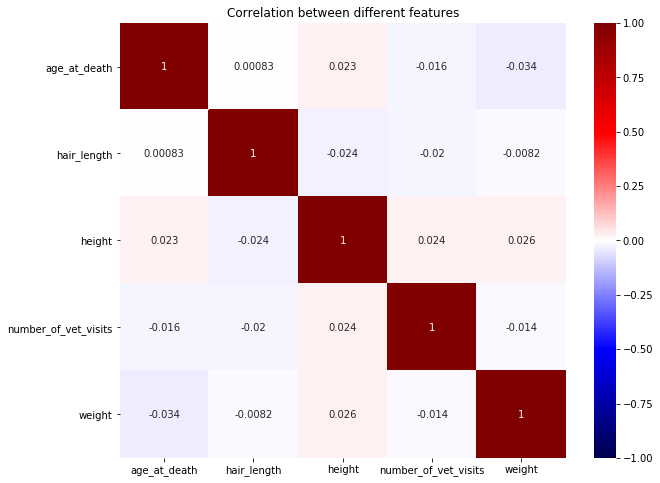

In [41]:
# Plot heatmap to visualize the correlations.
plt.figure(figsize = (10, 8))
# sns.heatmap(df.corr(), annot = True)
sns.heatmap(df_2000.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.title('Correlation between different features');

    We still dont notice any significant correlation between features

**Ordinary least squares (OLS) regression is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable**

In [42]:
# OLS regression model
import statsmodels.api as sm

Y = df_2000['age_at_death']
X = df_2000['hair_length']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results_hair_length = model.fit()
results_hair_length.params

const          8.872498
hair_length    0.023103
dtype: float64

In [43]:
Y = df_2000['age_at_death']
X = df_2000['number_of_vet_visits']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results_number_of_vet_visits = model.fit()
results_number_of_vet_visits.params

const                   9.001887
number_of_vet_visits   -0.012671
dtype: float64

In [44]:
Y = df_2000['age_at_death']
X = df_2000['height']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results_height = model.fit()
results_height.params

const     8.627995
height    0.012887
dtype: float64

In [45]:
Y = df_2000['age_at_death']
X = df_2000['weight']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results_weight = model.fit()
results_weight.params

const     9.090541
weight   -0.048833
dtype: float64

In [46]:
results_hair_length.tvalues

const          14.108958
hair_length     0.037227
dtype: float64

**Analysis:**

    Ordinary least squares (OLS) regression analysis shows us the relationship between 'hair_length','height','number_of_vet_visits','weight' features/variables show very low/independent of the target feature age_at_death.

**Solution:**
    
    Will need more varibales to predict the life expectancy of cats. These variables provided shows low correlation/dependency to the target feature.

End of document

Refrence: Stackoverflow